In [1]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Inputs

In [2]:
# Equilibrium contact angle (degrees)
th0 = 40.0

# Surface tension (N/m)
gamma = 17.7e-3 

# Temperature (K)
T = 296 

# Viscosity Pa.s
visco = 0.0023

# Critical velocity m/s
Ucrit = -1.744e-2

# Initial value for k0 (Hz)
k0 =75680.0

# Initial value for lambda (m)
lamb = 3.8e-9

# Boltzmann constant (J/K)
kB = 1.38066E-23

# Max number of iterations
maxIter = 100

# Tolerance to stop the iterative method
tol = 1.0e-3

# Contact line velocity (m/s)
Ucl = [0.0199, 0.0174, 0.0149, 0.0149, 0.0124, 0.0099, 0.0073, 0.0048,
       0.0029, 0.0008, 0.0001, 0.0001]

# Apparent contact angle (deg)
th = [52.48, 51.84, 51.58, 51.09, 49.7 , 48.76, 47.93, 47.59, 45.9 ,
       43.79, 42.51, 42.09]

In [3]:
# Methods

def estimations(k0, lamb, th0):
  # Full curve macroscopic and microscopic contact angle knowing:
  # k0: MKT jumping frequency (Hz)
  # lambda: MKT jumping length (m) 
  # Ucrit: critical contact line velocity (m/s)
  # Returns:
  # U: contact line velocity (m/s)
  # th: microscopic contact angle (deg)
  # thMacro: macroscopic contact angle (deg)

  th = np.linspace(0,180,1000)
  kBT  = kB*T
  a = 2*k0*lamb 
  b = gamma*lamb**2/(2*kBT) 
  U = a*np.sinh(b*(np.cos(th0*np.pi/180)-np.cos(th*np.pi/180)))

    # Estimation of the critical contact angle
  thCrit = 180/np.pi*np.arccos(np.cos(th0*np.pi/180)-2*kB*T/(gamma*lamb**2)*np.log(Ucrit/(2*k0*lamb)+np.sqrt((Ucrit/(2*k0*lamb))**2+1)))

  # Critical capillary number
  CaCrit = (Ucrit * visco) / gamma

  # L/Lm
  LLm = np.exp(-(thCrit*np.pi/180)**3 / (9 *CaCrit))

  # Macroscopic advance angle estimation
  thMacro = (180 / np.pi) *( ((th *np.pi) / 180)**3 +9 *visco*U/gamma * np.log(LLm))**(1. / 3.)

  return U, th, thMacro

def fitMKT(th, U, k0, lamb,th0):
  # MKT fitting
  # Inputs:
  # - th: microscopic contact angle (deg)
  # - U: contact line velocity (m/s)
  # - k0: initial value for k0 MKT (Hz)
  # - lamb: initial value for lambda MKT (m)
  # - th0: value of the equilibrium contact angle (deg)
  # Returns:
  # - k0: fitted k0 (Hz)
  # - lamb: fitted lamda (m)
  kBT  = kB*T
  a0 = 2*k0*lamb 
  b0 = gamma*lamb**2/(2*kBT) 
  th0Rad = th0*np.pi/180

  def fmkt(th,a,b):
      U = a*np.sinh(b*(np.cos(th0Rad)-np.cos(th*np.pi/180)))
      return U

  param_bounds=([0,0],[np.inf,np.inf])
  popt, pcov = curve_fit(fmkt, th, U, p0=(a0,b0),  bounds=param_bounds)
  a, b = popt[0],popt[1]
  lamb = np.sqrt((2 * kBT * b) / gamma)
  k0 = a / (2 * lamb)
  return k0,lamb


### Iterative method

In [5]:
# Conversion to numpy array
Ucl, th = np.array(Ucl), np.array(th)

# Capillary number
Ca = Ucl*visco/gamma

# Selector for the positive values of the contact line velocity
ic = Ucl>=0

# Lists to save the values
niter, sk0, slamb, sth0, sthCrit, sLLm = [],[],[],[],[], []


# Approximate the microscopic angle with the macroscopic angle in the first iteration
thMicro = th[::]

ncondition = 0
for iter in range(1,maxIter+1):
    # MKT fitting
    k0,lamb = fitMKT(thMicro[ic], Ucl[ic], k0,lamb,th0)

    # Estimation of the critical contact angle
    thCrit = 180/np.pi*np.arccos(np.cos(th0*np.pi/180)-2*kB*T/(gamma*lamb**2)*np.log(Ucrit/(2*k0*lamb)+np.sqrt((Ucrit/(2*k0*lamb))**2+1)))

    # Critical capillary number
    CaCrit = (Ucrit * visco) / gamma

    # L/Lm
    LLm = np.exp(-(thCrit*np.pi/180)**3 / (9 *CaCrit))

    # Microscopic advance angle estimation
    thMicro = (180 / np.pi) *( ((th *np.pi) / 180)**3 -9 *Ca * np.log(LLm))**(1. / 3.)

    # Condition to stop the iteration
    if iter>3 and abs(LLm-sLLm[-1]) < tol:
        # When the criteria is fulfill we let some extras iterations to see clearly the plateau
        ncondition +=1
        if ncondition == 5:
            break

       
    # Save values
    niter.append(iter)
    sk0.append(k0)
    slamb.append(lamb)
    sthCrit.append(thCrit)
    sLLm.append(LLm)

# Final curves
Ue, thMicroE, thMacroE = estimations(sk0[-1], slamb[-1], th0)

print("Final parameters")
print('-'*20)
print(f'k0 (MHz) = {sk0[-1]*1e-6:.4f}')
print(f'Lambda (nm) = {slamb[-1]*1e9:.3f}')
print(f'thCrit (deg) = {sthCrit[-1]:.2f}')
print(f'L/Lm = {sLLm[-1]:.2f}')

Final parameters
--------------------
k0 (MHz) = 0.1560
Lambda (nm) = 3.867
thCrit (deg) = 29.55
L/Lm = 832.36


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in power


### Dataframes

In [6]:
df = pd.DataFrame()
df['k0 [Hz]'] = sk0
df['lambda [m]'] = slamb
df['th_crit [deg]'] = sthCrit
df['L/Lm'] = sLLm
df

,k0 [Hz],lambda [m],th_crit [deg],L/Lm
0,466021.188940,2.834042e-09,23.831226,34.055544
1,285628.694774,3.282080e-09,26.939287,163.400511
2,215911.310013,3.545576e-09,28.243787,355.300486
3,185412.783651,3.693302e-09,28.872677,530.635392
4,170991.450018,3.773838e-09,29.192586,655.202243
5,163819.668510,3.817211e-09,29.359345,732.683325
6,160135.334945,3.840475e-09,29.447325,777.587028
7,158209.761909,3.852925e-09,29.494026,802.646650
8,157193.080409,3.859583e-09,29.518895,816.352661
9,156651.297003,3.863149e-09,29.532163,823.769827


### Plots

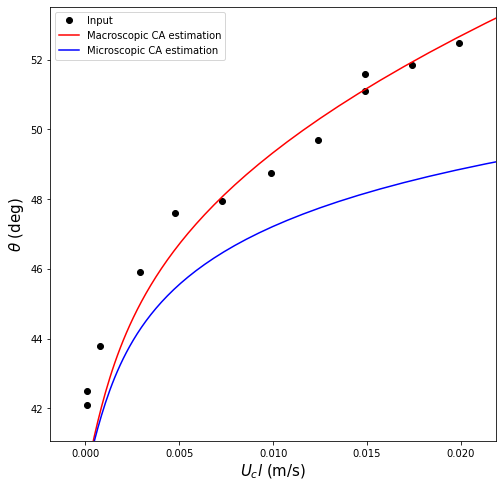

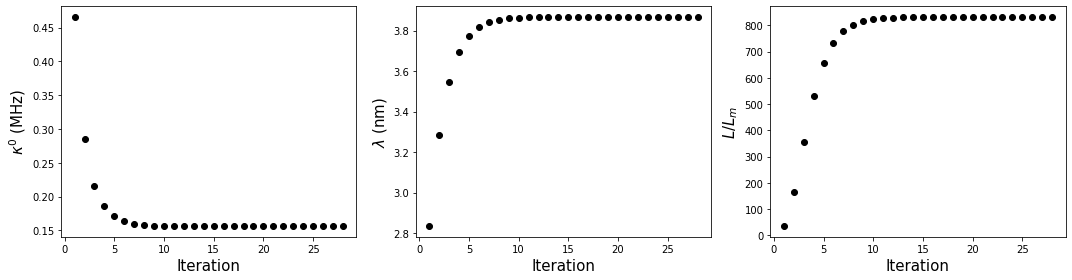

In [14]:
f, ax = plt.subplots(1, 1, figsize=(8,8))

# Macro and microscopic contact angle versus the contact line velocity
ax.plot(Ucl, th,'ko',label = "Input")
ax.plot(Ue, thMacroE, 'r-',label = "Macroscopic CA estimation")
ax.plot(Ue, thMicroE, 'b-',label = "Microscopic CA estimation")
ax.set_xlabel(r'$U_cl$ (m/s)', fontsize=15)
ax.set_ylabel(r'$\theta$ (deg)', fontsize=15)
ax.set_xlim(min(Ucl)-0.1*(max(Ucl)-min(Ucl)),max(Ucl)+0.1*(max(Ucl)-min(Ucl)))
ax.set_ylim(min(th)-0.1*(max(th)-min(th)),max(th)+0.1*(max(th)-min(th)))
ax.legend()


# Fitted values of k0, lambda and L/Lm versus the iteration number
f, ax = plt.subplots(1, 3, figsize=(15,4))
ax[0].plot(niter, np.array(sk0)*1e-6,'ko')
ax[0].set_xlabel('Iteration', fontsize=15)
ax[0].set_ylabel(r'$\kappa^0$ (MHz)', fontsize=15)

ax[1].plot(niter, np.array(slamb)*1e9,'ko')
ax[1].set_xlabel('Iteration', fontsize=15)
ax[1].set_ylabel(r'$\lambda$ (nm)', fontsize=15)

ax[2].plot(niter, sLLm,'ko')
ax[2].set_xlabel('Iteration', fontsize=15)
ax[2].set_ylabel(r'$L/L_m$', fontsize=15)

plt.tight_layout()